# Data Analysis Process
In this notebook, we are working on analyzing the enriched versions of Book-Crossing that we created in A. Data Enrichment Process.



## 0. Import Libraries
First, we are importing libraries that are needed for our process.

In [1]:
import time
import pandas as pd
import numpy as np
import pickle as pkl
from collections import Counter
import re
import math
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pywaffle import Waffle
from scipy.signal import find_peaks
from itertools import chain


We are setting the locations where we are saving our output files. The "large" location is used for files too large to be added on github - hence they are ignored during the git commit.

In [2]:
location_to_save = "data/final_files/"
large_location_to_save = "data/final_files/large_files/"

## 1. Analyze datasets

Read files. We are using the final versions of the datasets.

In [140]:
entire_books = pd.read_csv(location_to_save+"items_books_with_readable_properties_correct_ISBN.csv", low_memory=False, index_col=0).fillna("")
fairbook_books = pd.read_csv(location_to_save+"fairbook_books_with_readable_properties_correct_ISBN.csv", low_memory=False, index_col=0).fillna("")
entire_ratings = pd.read_csv(large_location_to_save+"entire_ratings_with_readable_properties_filtered_correct_ISBNs.csv", low_memory=False, index_col=0).fillna("")
fairbook_ratings = pd.read_csv(location_to_save+"fairbook_ratings_with_readable_properties_filtered_correct_ISBNs.csv", low_memory=False, index_col=0).fillna("")

<b>Note</b>: The entire_books and fairbook_books datasets still have the old ISBN column, which means some books are duplicate. We will drop based on ISBN_alt.

In [141]:
entire_books = entire_books.drop_duplicates("ISBN_alt")
fairbook_books = fairbook_books.drop_duplicates("ISBN_alt")

In [142]:
# gather all the datasets
dfs = [entire_books.copy(), entire_ratings.copy(), fairbook_books.copy(), fairbook_ratings.copy()]

In [143]:
dfs_names = ['entire books', 'entire ratings', 'fairbook books', 'fairbook ratings']

Choose color map.

In [144]:
color_map=mcp.gen_color(cmap="Pastel2",n=8)
print(color_map)

['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4', '#e6f5c9', '#fff2ae', '#f1e2cc', '#cccccc']


### 1.a. Gender
<b>Goal</b>: To analyze the gender distribution in the datasets.

Overview.

In [145]:
i=0
print("===============")
for df in dfs:
    print(dfs_names[i]+":")
    print("---------------")
    print(Counter(df.gender).most_common()[:5])
    print("===============")
    i+=1

entire books:
---------------
[('male', 86800), ('', 79013), ('female', 50655), ('transgender female', 57), ('male,female', 47)]
entire ratings:
---------------
[('male', 466151), ('female', 375316), ('', 179688), ('transgender male', 292), ('transgender female', 163)]
fairbook books:
---------------
[('male', 2605), ('female', 2466), ('', 425), ('transgender male', 4), ('transgender female', 3)]
fairbook ratings:
---------------
[('male', 42933), ('female', 39847), ('', 3515), ('transgender male', 34), ('transgender female', 22)]



Given how the big majority of the authors are either flagged as "male" or "female", we for now focus on these two cases. <u>However, this should be resolved in future iteration.</u> 

In [146]:
for df in dfs:
    # replace empty string with "unknown"
    df["gender"] = df["gender"].apply(lambda x: "unknown" if x=="" else x)
    # flag as "other" if neither male, nor female, nor unknown
    df["gender"] = df["gender"].apply(lambda x: "other" if (x!="male")&(x!="female")&(x!="unknown") else x) 

Set color for every gender value.

In [147]:
colors = {}
i = 0
for gender_value in dfs[0].gender.unique(): #entire_books definitely contains all possible values
    colors[gender_value] = color_map[i]
    i+=1

In [148]:
print(colors)

{'unknown': '#b3e2cd', 'male': '#fdcdac', 'female': '#cbd5e8', 'other': '#f4cae4'}


Make graphs.

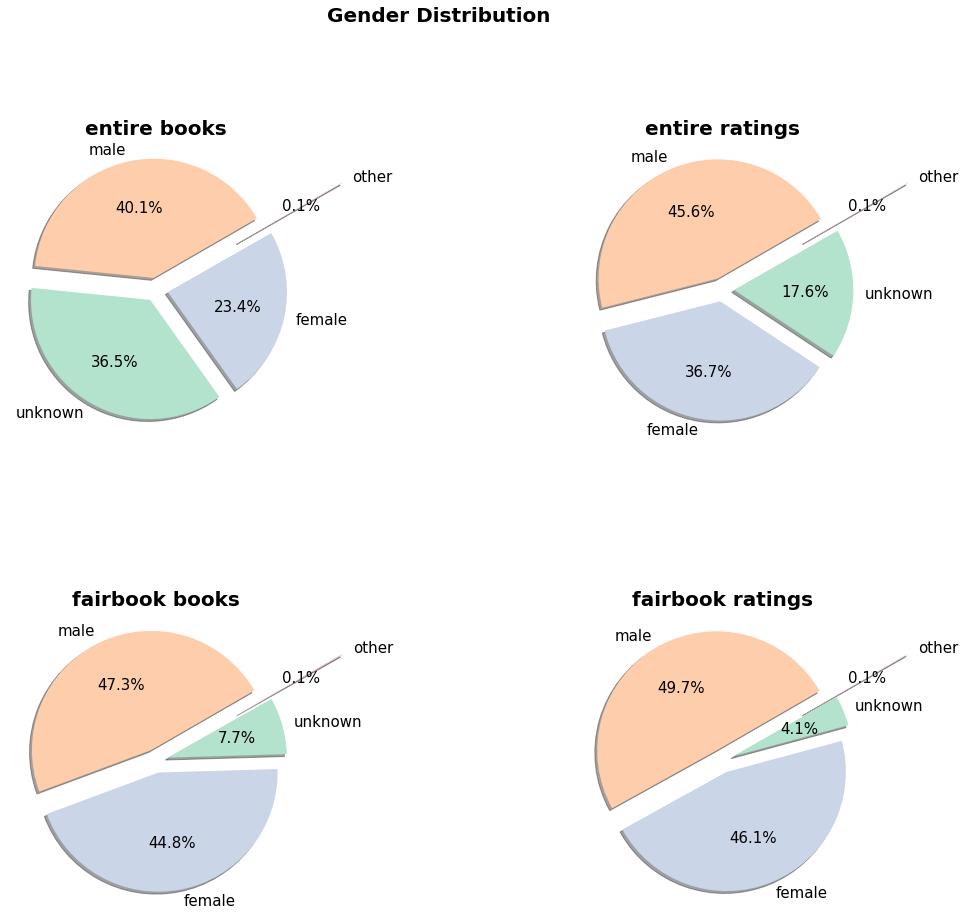

In [149]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
for i in range(len(dfs)):
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    dfs[i].gender.value_counts().plot(kind="pie",autopct='%1.1f%%',explode=(0.1, 0.1, 0.1,0.8), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)],
                                      textprops={'color':'black', 'fontsize':15},
                                     colors=[colors[v] for v in dfs[i]['gender'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].set_title(dfs_names[i],fontdict={'fontsize':20, 'weight':'bold'})
    axes[int(j1),int(j2)].set_ylabel('')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)

fig.suptitle('Gender Distribution',fontsize = 20, weight="bold") 
fig.show()


### 1.b. Country
<b>Goal</b>: To review the author country of citizenship distribution in the datasets.

Overview.

In [128]:
i=0
print("===============")
for df in dfs:
    print(dfs_names[i]+":")
    print("---------------")
    print(Counter(df.country).most_common()[:5])
    print("===============")
    i+=1

entire books:
---------------
[('', 91745), ('United States of America', 70573), ('United Kingdom', 17299), ('France', 3888), ('Canada', 3355)]
entire ratings:
---------------
[('United States of America', 565198), ('', 213253), ('United Kingdom', 85574), ('Canada', 17536), ('France', 11402)]
fairbook books:
---------------
[('United States of America', 3771), ('', 515), ('United Kingdom', 470), ('Canada', 100), ('Republic of Ireland', 46)]
fairbook ratings:
---------------
[('United States of America', 64214), ('United Kingdom', 7847), ('', 4537), ('Canada', 1445), ('Republic of Ireland', 901)]


We notice that each dataset has different most common countries.

Simplify some country names for the graphs.

In [129]:
for df in dfs:
    # replace empty string with "unknown"
    df["country"] = df["country"].apply(lambda x: "unknown" if x=="" else x)
    # simplify country names
    df["country"] = df["country"].apply(lambda x: "USA" if x=="United States of America" else x)
    df["country"] = df["country"].apply(lambda x: "UK" if x=="United Kingdom" else x)
    df["country"] = df["country"].apply(lambda x: "Ireland" if x=="Republic of Ireland" else x)
    

Find most common countries for each dataset.

In [130]:
all_most_common = []
for df in dfs:
    most_common_5 = [x[0] for x in Counter(df.country).most_common()[:5]] # most common countries for this dataset
    all_most_common.append(most_common_5)

In [131]:
all_most_common

[['unknown', 'USA', 'UK', 'France', 'Canada'],
 ['USA', 'unknown', 'UK', 'Canada', 'France'],
 ['USA', 'unknown', 'UK', 'Canada', 'Ireland'],
 ['USA', 'UK', 'unknown', 'Canada', 'Ireland']]

In [132]:
unique_common_countries = list(np.unique(list(chain(*all_most_common))))

In [133]:
unique_common_countries

['Canada', 'France', 'Ireland', 'UK', 'USA', 'unknown']

Change every country to "other" if it is not one of the most common <b>for this dataset</b>.

In [134]:
i=0
for df in dfs:
    df["country"] = df["country"].apply(lambda x: "other" if x not in all_most_common[i] else x)
    i+=1

Add "other" to most common and set colors.

In [135]:
unique_common_countries.append("other")

In [136]:
colors = {}
i = 0
for country_value in unique_common_countries: #entire_books definitely contains all possible values
    colors[country_value] = color_map[i]
    i+=1

Make graphs.

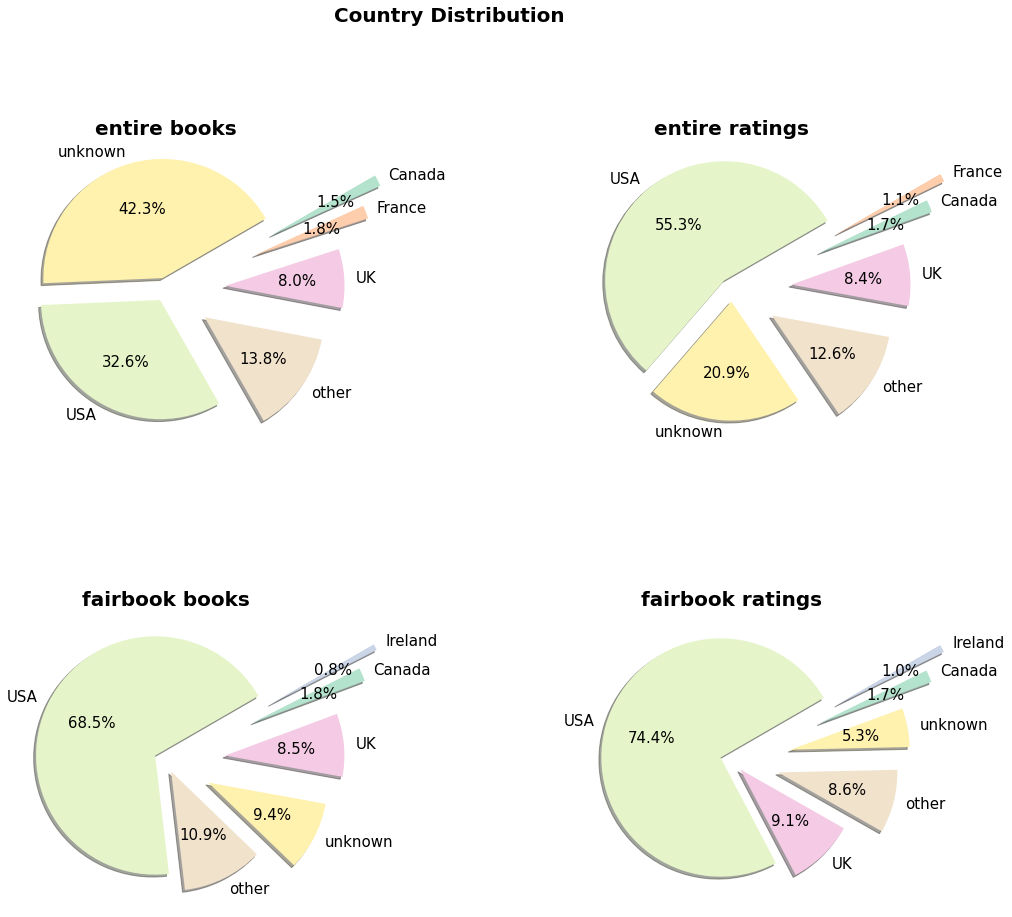

In [138]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
for i in range(len(dfs)):
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    dfs[i].country.value_counts().plot(kind="pie",autopct='%1.1f%%',explode=(0.1, 0.1, 0.4,0.5, 0.8,1), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)],
                                      textprops={'color':'black', 'fontsize':15},
                                     colors=[colors[v] for v in dfs[i]['country'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].set_title(dfs_names[i],fontdict={'fontsize':20, 'weight':'bold'})
    axes[int(j1),int(j2)].set_ylabel('')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)

fig.suptitle('Country Distribution',fontsize = 20, weight="bold") 
fig.show()


## Analyze Language

In [41]:
for df in dfs:
    df["language"] = df["language"].apply(lambda x: "unknown" if x=="" else x)
    #df["gender"][(df.gender!="male") & (df.gender!="female") & (df.gender!="unknown")] = "other"

In [42]:
check_most_common("language")

False

In [43]:
most_common_5 = [x[0] for x in Counter(fairbook_ratings.country).most_common()[:5]]

/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

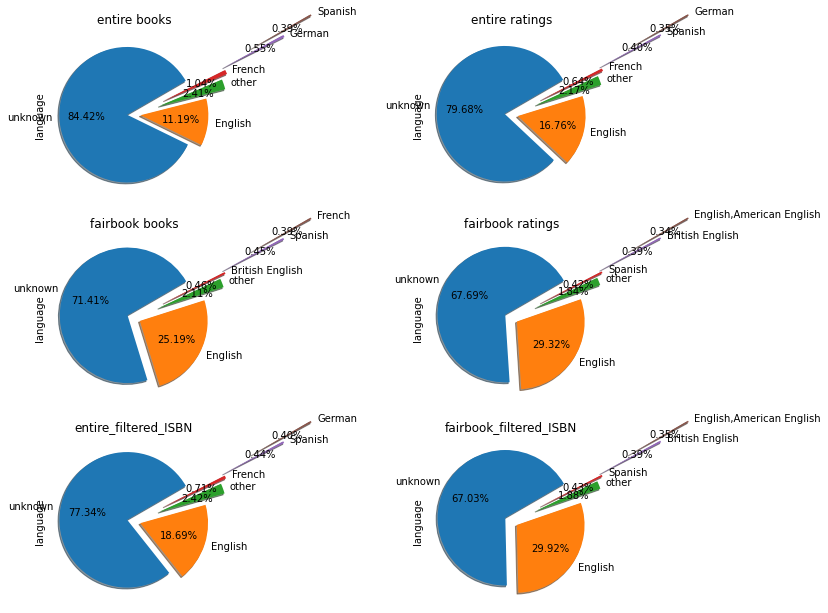

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    
    df = dfs[i].copy()
    most_common_5 = [x[0] for x in Counter(df.language).most_common()[:5]]
    df["language"][df.language.isin(most_common_5) == False] = "other"
    
    
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.language.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.1, 0.4,0.5, 1.5,2), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)])
    #, 
     #                              colors=[colors[v] for v in df['country'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
fig.show()

## Analyze birthyear

/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

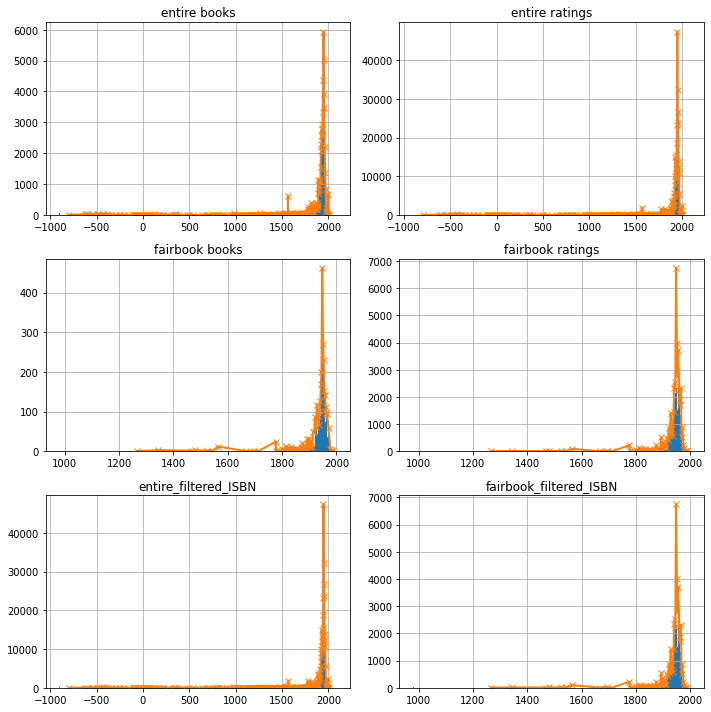

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    df = dfs[i].copy()
    c = df[df.birthyear!=""]
    c.birthyear = c.birthyear.astype("float")
    max_frequency = c['birthyear'].value_counts().max()
    #print(max_frequency)
#     print(c.birthyear.mode().iloc[0])
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    
    n = math.ceil((c.birthyear.max() - c.birthyear.min()))
#     print(n)
    c.hist(column="birthyear", bins=n,ax=axes[int(j1),int(j2)])
#     df.country.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.3, 0.4,0.1, 0.5,1.5), shadow=True
#                                       , startangle=30, ax=axes[int(j1),int(j2)], 
#                                    colors=[colors[v] for v in df['country'].value_counts().keys()])

    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
    
    
    hist, bin_edges = np.histogram(list(c.birthyear), int(max(c.birthyear)-min(c.birthyear)))
    bin_edges = bin_edges[1:]
    peaks, _ = find_peaks(hist)
    axes[int(j1),int(j2)].plot(bin_edges[peaks], hist[peaks],linewidth=2, marker ='x')
    
    #axes[int(j1),int(j2)].set_ylim(0,max_frequency)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.9, 
#                     hspace=0.2)    
fig.tight_layout()
fig.show()

In [46]:
for df in dfs:
    df["birthyear_coded"] = df["birthyear"].apply(lambda x: "1000000" if x=="" else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "2000000" if int(x)<0 else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "3000000" if (int(x)>=0)&(int(x)<1900) else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "4000000" if (int(x)>=1900)&(int(x)<1950) else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "5000000" if (int(x)>=1950)&(int(x)<200000) else x)

In [47]:
for df in dfs:
    df.birthyear_coded = df.birthyear_coded.replace("1000000","unknown")
    df.birthyear_coded = df.birthyear_coded.replace("2000000","B.C.")
    df.birthyear_coded = df.birthyear_coded.replace("3000000","0-1900")
    df.birthyear_coded = df.birthyear_coded.replace("4000000","1900-1950")
    df.birthyear_coded = df.birthyear_coded.replace("5000000","1950-2000")

In [48]:
colors={'1900-1950':'#1f77b4', 
        '1950-2000':'#d62728',
       "unknown":"#2ca02c",
       "0-1900":"#ff7f0e",
       "B.C.":"black"}

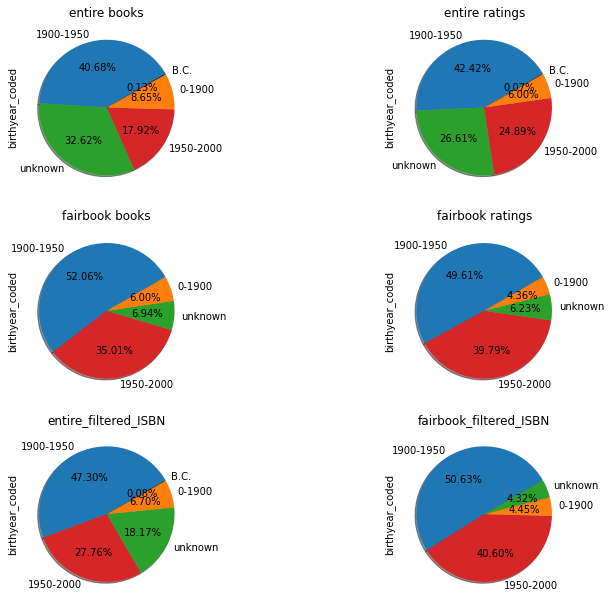

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    
    df = dfs[i].copy()
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.birthyear_coded.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)]
                                     ,colors=[colors[v] for v in df['birthyear_coded'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
#fig.show()

In [50]:
for df in dfs:
    for index, row in df.iterrows():
        if (row.birthyear_coded == "1950-2000") | (row.birthyear_coded == "1900-1950"):
            year = row.birthyear
            year_rounded_down = math.floor(year/10)*10
            df.at[index, "birthyear_coded"] = str(year_rounded_down)+"s"

In [51]:
dfs[0].birthyear_coded.unique()

array(['unknown', '1930s', '1940s', '1950s', '1960s', '1970s', '0-1900',
       '1920s', '1900s', '1910s', '2000s', '1980s', '1990s', 'B.C.',
       '2080s'], dtype=object)

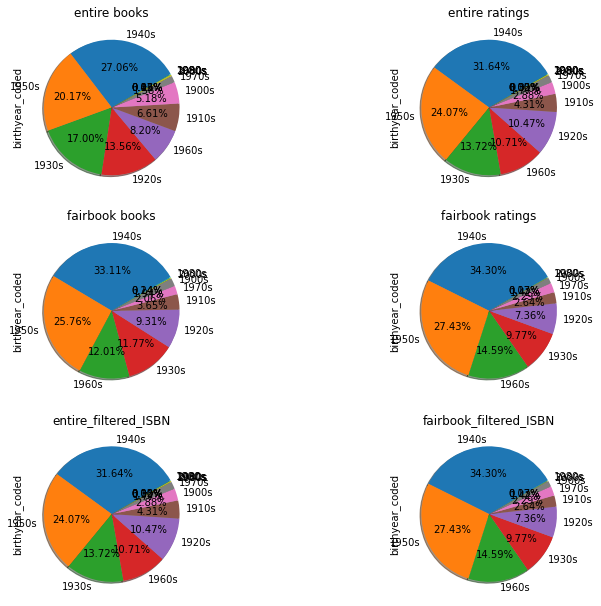

In [52]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    
    df = dfs[i].copy()
    df = df[(df.birthyear_coded!="unknown")&(df.birthyear_coded!="B.C.")&(df.birthyear_coded!="0-1900")]
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.birthyear_coded.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)]
                                     )
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
#fig.show()

In [53]:
dfs[0][dfs[0].birthyear_coded == "2000s"].birthyear.unique()

array([2000.0, 2002.0], dtype=object)

In [ ]:
# 15. Analyze datasets.

A. Read files.

entire_books = pd.read_csv(location_to_save+"items_books_with_readable_properties.csv", low_memory=False, index_col=0).fillna("")
entire_ratings = pd.read_csv(large_location_to_save+"entire_ratings_with_readable_properties.csv", low_memory=False, index_col=0).fillna("")
fairbook_books = pd.read_csv(location_to_save+"fairbook_books_with_readable_properties.csv", low_memory=False, index_col=0).fillna("")
fairbook_ratings = pd.read_csv(location_to_save+"fairbook_ratings_with_readable_properties.csv", low_memory=False, index_col=0).fillna("")

entire_ratings_filtered_ISBN = pd.read_csv(large_location_to_save+"entire_ratings_with_readable_properties_filtered_ISBNs.csv", low_memory=False, index_col=0).fillna("")
fairbook_ratings_filtered_ISBN = pd.read_csv(location_to_save+"fairbook_ratings_with_readable_properties_filtered_ISBNs.csv", low_memory=False, index_col=0).fillna("")

dfs = [entire_books, entire_ratings, fairbook_books, fairbook_ratings, entire_ratings_filtered_ISBN, fairbook_ratings_filtered_ISBN]

dfs_names = ['entire books', 'entire ratings', 'fairbook books', 'fairbook ratings', "entire_filtered_ISBN", "fairbook_filtered_ISBN"]

## Analyze gender

i = 0 
for df in dfs:
    print(dfs_names[i])
    df["gender"] = df["gender"].apply(lambda x: "unknown" if x=="" else x)
    df["gender"][(df.gender!="male") & (df.gender!="female") & (df.gender!="unknown")] = "other"
    i += 1

colors={'male':'#1f77b4', 
        'other':'#d62728',
       "female":"#ff7f0e",
       "unknown":"#2ca02c"}

fig, axes = plt.subplots(nrows=3, ncols=2)
for i in range(len(dfs)):
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    dfs[i].gender.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.1, 0.1,0.8), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)],
                                     colors=[colors[v] for v in df['gender'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
fig.tight_layout()
#fig.suptitle("Gender Distribution")
#fig.show()

def check_most_common(column):
    most_common_5=[]
    for df in dfs:
        most_common_5.append(set([x[0] for x in Counter(df[column]).most_common()[:5]]))
    return len(np.unique(most_common_5))==1

## Analyze country

check_most_common("country")

for df in dfs:
    df["country"] = df["country"].apply(lambda x: "unknown" if x=="" else x)

most_common_5 = [x[0] for x in Counter(fairbook_ratings.country).most_common()[:5]]

for df in dfs:
    df["country"][df.country.isin(most_common_5) == False] = "other"

colors={'USA':'#1f77b4', 
        'UK':'#d62728',
       "Ireland":"#8c564b",
       "unknown":"#ff7f0e",
       "Canada":"#9467bd",
       "other":"#2ca02c"}

fig, axes = plt.subplots(nrows=3, ncols=2)
for i in range(len(dfs)):
    df = dfs[i].copy()
    df.country = df.country.replace("United States of America", "USA")
    df.country = df.country.replace("United Kingdom", "UK")
    df.country = df.country.replace("Republic of Ireland", "Ireland")
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.country.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.3, 0.4,0.1, 0.5,1.5), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)], 
                                   colors=[colors[v] for v in df['country'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
    
fig.tight_layout()
#fig.suptitle("Gender Distribution")
fig.show()

## Analyze Language

for df in dfs:
    df["language"] = df["language"].apply(lambda x: "unknown" if x=="" else x)
    #df["gender"][(df.gender!="male") & (df.gender!="female") & (df.gender!="unknown")] = "other"

check_most_common("language")

most_common_5 = [x[0] for x in Counter(fairbook_ratings.country).most_common()[:5]]

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    
    df = dfs[i].copy()
    most_common_5 = [x[0] for x in Counter(df.language).most_common()[:5]]
    df["language"][df.language.isin(most_common_5) == False] = "other"
    
    #df.country = df.country.replace("United States of America", "USA")
    #df.country = df.country.replace("United Kingdom", "UK")
    #df.country = df.country.replace("Republic of Ireland", "Ireland")
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.language.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.1, 0.4,0.5, 1.5,2), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)])
    #, 
     #                              colors=[colors[v] for v in df['country'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
fig.show()

## Analyze birthyear

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    df = dfs[i].copy()
    c = df[df.birthyear!=""]
    c.birthyear = c.birthyear.astype("float")
    max_frequency = c['birthyear'].value_counts().max()
    #print(max_frequency)
#     print(c.birthyear.mode().iloc[0])
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    
    n = math.ceil((c.birthyear.max() - c.birthyear.min()))
#     print(n)
    c.hist(column="birthyear", bins=n,ax=axes[int(j1),int(j2)])
#     df.country.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.3, 0.4,0.1, 0.5,1.5), shadow=True
#                                       , startangle=30, ax=axes[int(j1),int(j2)], 
#                                    colors=[colors[v] for v in df['country'].value_counts().keys()])

    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
    
    
    hist, bin_edges = np.histogram(list(c.birthyear), int(max(c.birthyear)-min(c.birthyear)))
    bin_edges = bin_edges[1:]
    peaks, _ = find_peaks(hist)
    axes[int(j1),int(j2)].plot(bin_edges[peaks], hist[peaks],linewidth=2, marker ='x')
    
    #axes[int(j1),int(j2)].set_ylim(0,max_frequency)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.9, 
#                     hspace=0.2)    
fig.tight_layout()
fig.show()

for df in dfs:
    df["birthyear_coded"] = df["birthyear"].apply(lambda x: "1000000" if x=="" else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "2000000" if int(x)<0 else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "3000000" if (int(x)>=0)&(int(x)<1900) else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "4000000" if (int(x)>=1900)&(int(x)<1950) else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "5000000" if (int(x)>=1950)&(int(x)<200000) else x)

for df in dfs:
    df.birthyear_coded = df.birthyear_coded.replace("1000000","unknown")
    df.birthyear_coded = df.birthyear_coded.replace("2000000","B.C.")
    df.birthyear_coded = df.birthyear_coded.replace("3000000","0-1900")
    df.birthyear_coded = df.birthyear_coded.replace("4000000","1900-1950")
    df.birthyear_coded = df.birthyear_coded.replace("5000000","1950-2000")

colors={'1900-1950':'#1f77b4', 
        '1950-2000':'#d62728',
       "unknown":"#2ca02c",
       "0-1900":"#ff7f0e",
       "B.C.":"black"}

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    
    df = dfs[i].copy()
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.birthyear_coded.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)]
                                     ,colors=[colors[v] for v in df['birthyear_coded'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
#fig.show()

for df in dfs:
    for index, row in df.iterrows():
        if (row.birthyear_coded == "1950-2000") | (row.birthyear_coded == "1900-1950"):
            year = row.birthyear
            year_rounded_down = math.floor(year/10)*10
            df.at[index, "birthyear_coded"] = str(year_rounded_down)+"s"

dfs[0].birthyear_coded.unique()

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    
    df = dfs[i].copy()
    df = df[(df.birthyear_coded!="unknown")&(df.birthyear_coded!="B.C.")&(df.birthyear_coded!="0-1900")]
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.birthyear_coded.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)]
                                     )
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
#fig.show()

dfs[0][dfs[0].birthyear_coded == "2000s"].birthyear.unique()

# Graphs

# Finally make graphs.

### Set colormaps

### Read data

Here are the files I will be using!

In [106]:
entire_books = pd.read_csv(location_to_save+"items_books_with_readable_properties_correct_ISBN.csv", low_memory=False, index_col=0).fillna("")
entire_ratings = pd.read_csv(large_location_to_save+"entire_ratings_with_readable_properties_filtered_correct_ISBNs.csv", low_memory=False, index_col=0).fillna("")
fairbook_ratings = pd.read_csv(location_to_save+"fairbook_ratings_with_readable_properties_filtered_correct_ISBNs.csv", low_memory=False, index_col=0).fillna("")
fairbook_books = pd.read_csv(location_to_save+"fairbook_books_with_readable_properties_correct_ISBN.csv", low_memory=False, index_col=0).fillna("")

Just a small final test

In [107]:
fairbook_ratings.head(1)

,User-ID,ISBN,Book-Rating,title,author,year,publisher,alt_title,alt_author,correct_author,...,QID,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,label
1,276847,3551551677,10,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Stein der Weisen,Joanne K. Rowling,Joanne K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965,,J. K. Rowling


The above makes sense because not all the books are in the ratings!

## Entire ratings

In [69]:
entire_ratings_country = pd.DataFrame(entire_ratings["country"])
entire_ratings_country["country"] = entire_ratings_country["country"].apply(lambda x: "unknown" if x=="" else x)

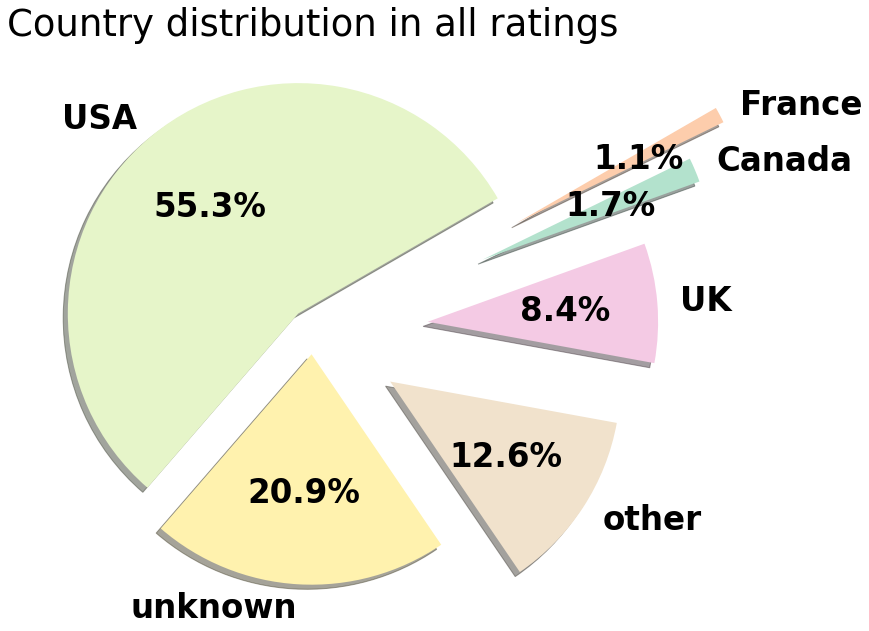

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
df = entire_ratings_country.copy()
df.country = df.country.replace("United States of America", "USA")
df.country = df.country.replace("United Kingdom", "UK")
df.country = df.country.replace("Republic of Ireland", "Ireland")
most_common_5 = [x[0] for x in Counter(df.country).most_common()[:5]]
df["country"][df.country.isin(most_common_5) == False] = "other"
most_common_6 = [x[0] for x in Counter(df.country).most_common()[:6]]

df.country.value_counts().plot(kind="pie",explode=(0.1, 0.1, 0.4,0.5, 0.8,1), shadow=True
                                      , startangle=30, ax=ax,  autopct='%1.1f%%',
                              textprops={'color':'black', 'weight':'bold', 'fontsize':32.5}
                              ,colors=[colors[key] for key in most_common_6])
ax.tick_params(labelrotation=0)
ax.set_title("Country distribution in all ratings", fontdict={'fontsize': 37})
#plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
plt.ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
fig.show()

In [71]:
df.country.value_counts()/len(df)*100

USA        55.311412
unknown    20.869367
other      12.612847
UK          8.374444
Canada      1.716108
France      1.115823
Name: country, dtype: float64

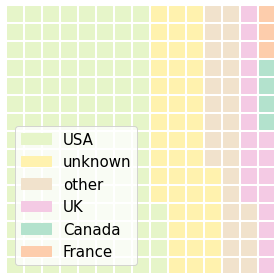

In [72]:
calculated = df.country.value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=15, 
    columns=15,
    values=list(calculated.values),
    labels=list(calculated.index),
    legend={
        'loc': 'lower left',
        'fontsize': 15
    },
    colors=[colors[key] for key in most_common_6],
)

plt.show()

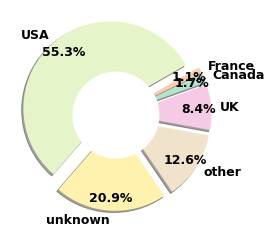

In [73]:
#fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))

df.country.value_counts().plot(kind="pie",explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1), shadow=True
                                      , startangle=30,  autopct='%1.1f%%',
                              textprops={'color':'black', 'weight':'bold', 'fontsize':12.5}
                              ,colors=[colors[key] for key in most_common_6], pctdistance=0.85)
centre_circle = plt.Circle((0, 0), 0.5, fc = "white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.ylabel('')
plt.show()

# Entire books

In [117]:
len(entire_books)

271360

In [116]:
len(entire_books.drop_duplicates("ISBN_alt"))

216657

In [118]:
len(entire_books.drop_duplicates("ISBN"))

271360

In [74]:
entire_books_country = pd.DataFrame(entire_books.drop_duplicates("ISBN")["country"])
entire_books_country["country"] = entire_books_country["country"].apply(lambda x: "unknown" if x=="" else x)

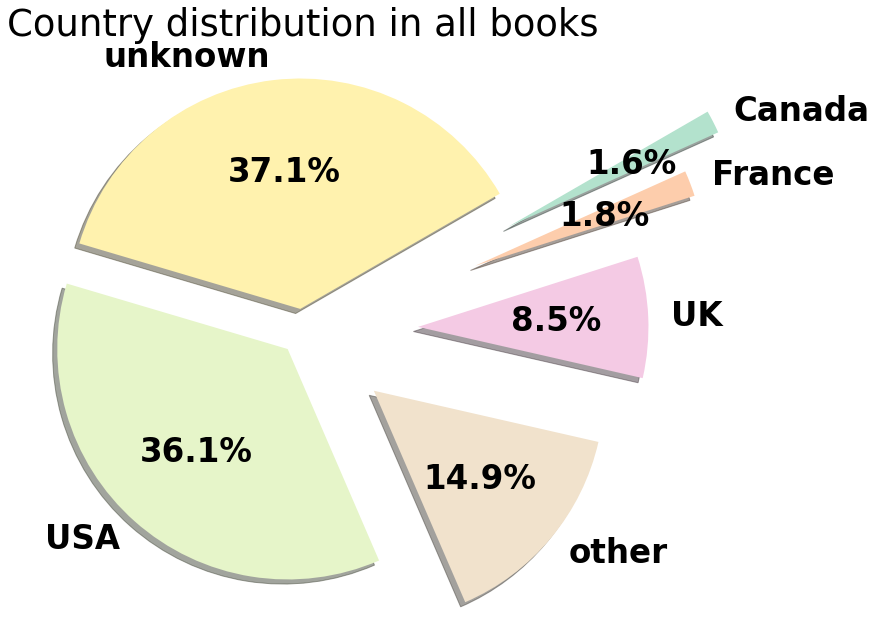

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
df = entire_books_country.copy()
df.country = df.country.replace("United States of America", "USA")
df.country = df.country.replace("United Kingdom", "UK")
df.country = df.country.replace("Republic of Ireland", "Ireland")
most_common_5 = [x[0] for x in Counter(df.country).most_common()[:5]]
df["country"][df.country.isin(most_common_5) == False] = "other"
most_common_6 = [x[0] for x in Counter(df.country).most_common()[:6]]

df.country.value_counts().plot(kind="pie",explode=(0.1, 0.1, 0.4,0.5, 0.8,1), shadow=True
                                      , startangle=30, ax=ax,  autopct='%1.1f%%',
                              textprops={'color':'black', 'weight':'bold', 'fontsize':32.5}
                              ,colors=[colors[key] for key in most_common_6])
ax.tick_params(labelrotation=0)
ax.set_title("Country distribution in all books", fontdict={'fontsize': 37})
#plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
plt.ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
fig.show()

In [76]:
df.country.value_counts()/len(df)*100

unknown    37.080631
USA        36.079378
other      14.937721
UK          8.490198
France      1.803140
Canada      1.608933
Name: country, dtype: float64

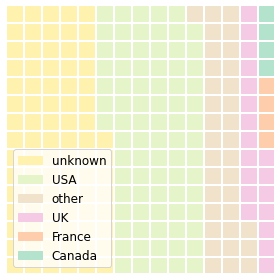

In [77]:
calculated = df.country.value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=15, 
    columns=15,
    values=list(calculated.values),
    labels=list(calculated.index),
    legend={
        'loc': 'lower left',
        'fontsize': 12
    },
    colors=[colors[key] for key in most_common_6]
)

plt.show()

## Fairbook ratings

In [78]:
fairbook_ratings_country = pd.DataFrame(fairbook_ratings["country"])
fairbook_ratings_country["country"] = fairbook_ratings_country["country"].apply(lambda x: "unknown" if x=="" else x)

In [81]:
most_common_6

['USA', 'UK', 'other', 'unknown', 'Canada', 'Republic of Ireland']

In [82]:
most_common_5

['USA', 'UK', 'unknown', 'Canada', 'Republic of Ireland']

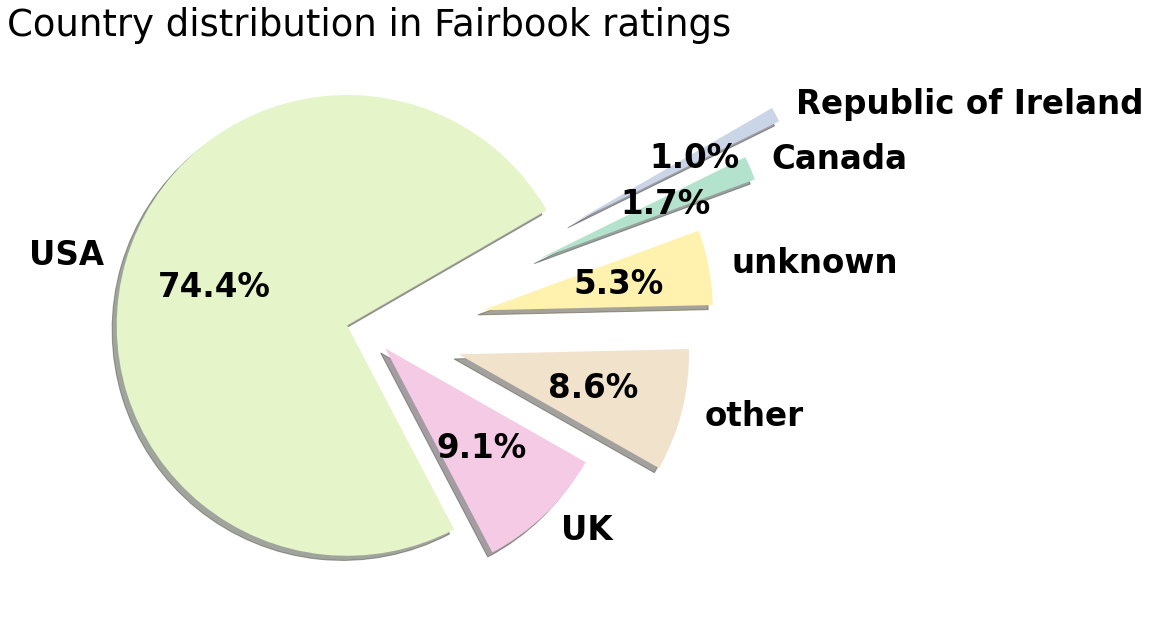

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
df = fairbook_ratings_country.copy()
df.country = df.country.replace("United States of America", "USA")
df.country = df.country.replace("United Kingdom", "UK")
#df.country = df.country.replace("Republic of Ireland", "Ireland")
most_common_5 = [x[0] for x in Counter(df.country).most_common()[:5]]
df["country"][df.country.isin(most_common_5) == False] = "other"
most_common_6 = [x[0] for x in Counter(df.country).most_common()[:6]]

df.country.value_counts().plot(kind="pie",explode=(0.1, 0.1, 0.4,0.5, 0.8,1), shadow=True
                                      , startangle=30, ax=ax,  autopct='%1.1f%%',
                              textprops={'color':'black', 'weight':'bold', 'fontsize':32.5}
                              , colors=[colors[key] for key in most_common_6])
ax.tick_params(labelrotation=0)
ax.set_title("Country distribution in Fairbook ratings", fontdict={'fontsize': 37})
#plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
plt.ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
fig.show()

In [80]:
df.country.value_counts()/len(df)*100

USA                    74.359628
UK                      9.086803
other                   8.583075
unknown                 5.253833
Canada                  1.673306
Republic of Ireland     1.043355
Name: country, dtype: float64

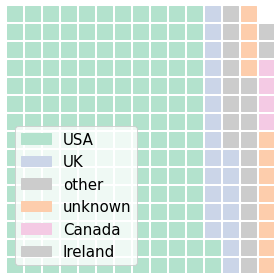

In [34]:
calculated = df.country.value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=15, 
    columns=15,
    values=list(calculated.values),
    labels=list(calculated.index),
    legend={
        'loc': 'lower left',
        'fontsize': 15
    },
    colors=[colors[key] for key in most_common_6]
)

plt.show()

# Fairbook books

In [108]:
fairbook_books_country = pd.DataFrame(fairbook_books.drop_duplicates("ISBN_alt")["country"])
fairbook_books_country["country"] = fairbook_books_country["country"].apply(lambda x: "unknown" if x=="" else x)

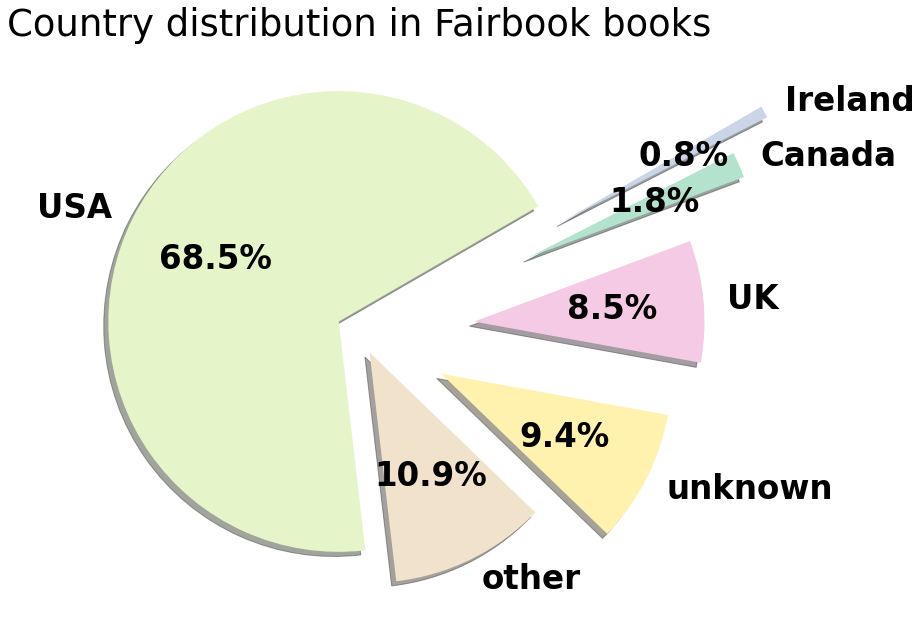

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
df = fairbook_books_country.copy()
df.country = df.country.replace("United States of America", "USA")
df.country = df.country.replace("United Kingdom", "UK")
df.country = df.country.replace("Republic of Ireland", "Ireland")
most_common_5 = [x[0] for x in Counter(df.country).most_common()[:5]]
df["country"][df.country.isin(most_common_5) == False] = "other"
most_common_6 = [x[0] for x in Counter(df.country).most_common()[:6]]

df.country.value_counts().plot(kind="pie",explode=(0.1, 0.1, 0.4,0.5, 0.8,1), shadow=True
                                      , startangle=30, ax=ax,  autopct='%1.1f%%',
                              textprops={'color':'black', 'weight':'bold', 'fontsize':32.5}
                              , colors=[colors[key] for key in most_common_6])
ax.tick_params(labelrotation=0)
ax.set_title("Country distribution in Fairbook books", fontdict={'fontsize': 37})
#plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})
plt.ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
fig.show()

In [94]:
df.country.value_counts()/len(df)*100

USA        68.513808
other      10.937500
unknown     9.356831
UK          8.539244
Canada      1.816860
Ireland     0.835756
Name: country, dtype: float64

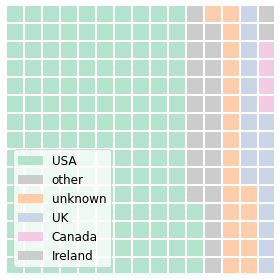

In [95]:
calculated = df.country.value_counts()
fig = plt.figure(
    FigureClass=Waffle, 
    rows=15, 
    columns=15,
    values=list(calculated.values),
    labels=list(calculated.index),
    legend={
        'loc': 'lower left',
        'fontsize': 12
    },
    colors=[colors[key] for key in most_common_6]
)

plt.show()